In [13]:
import dask
import numpy
import starepandas
import geopandas
import pystare
import pandas
import matplotlib.pyplot as plt

In [2]:
us = geopandas.read_file('data/tl_2017_us_state/tl_2017_us_state.shp')
us = us.to_crs('EPSG:4326')
len(us)

56

In [3]:
us.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62537, -82.98748 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


# Parallel SID lookup

## Manual / low level

In [4]:
n_cores = 55

ddf = dask.dataframe.from_pandas(us.geometry, npartitions=n_cores)
meta = {'stare': 'int64'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.stare_from_geoseries(df, 7)), meta=meta)
stare = res.compute(scheduler='processes')

## High level

In [5]:
stare = starepandas.stare_from_geoseries(us.geometry, level=7, nonconvex=True, force_ccw=True, n_workers=55)

# Parallel Trixel lookup

## Manual / low level

In [7]:
n_cores = 55

ddf = dask.dataframe.from_pandas(us['stare'], npartitions=n_cores)
meta = {'trixels': 'object'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.trixels_from_stareseries(df)), meta=meta)
trixels = res.compute(scheduler='processes')

## High level

In [14]:
stare = pandas.Series(stare)
trixels = starepandas.trixels_from_stareseries(stare, n_workers=55)

# Parallel instantiation

In [15]:
us = starepandas.STAREDataFrame(us, add_stare=True, level=7, add_trixels=True, n_workers=55)

<AxesSubplot:>

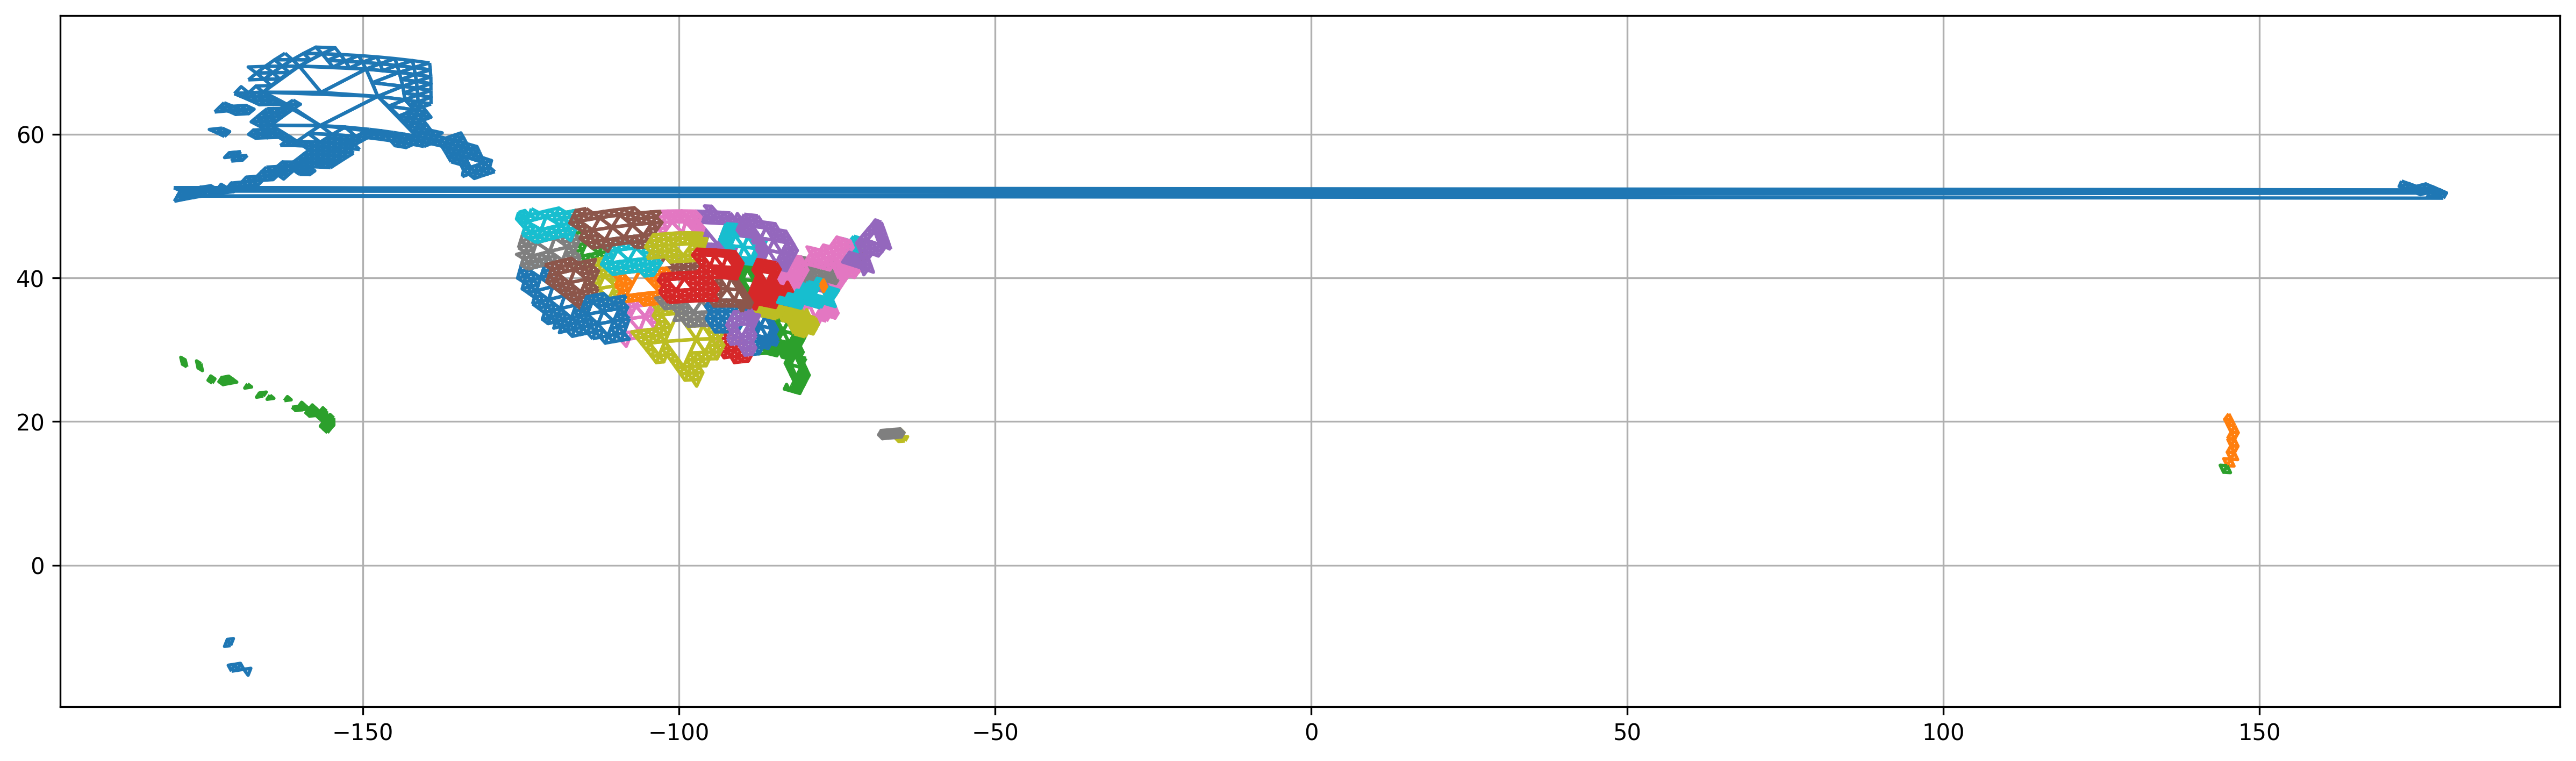

In [16]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
ax.grid(True)

us.plot(ax=ax, trixels=True, column='NAME')

# Visualization

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stare,trixels
31,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,16634117742,11777681513,+22.0120383,-159.7059653,"MULTIPOLYGON (((-166.38653 23.84636, -166.3842...","[1158902847861948423, 1159149138466570247, 115...",(POLYGON ((-165.7746047773546 23.5351684087914...


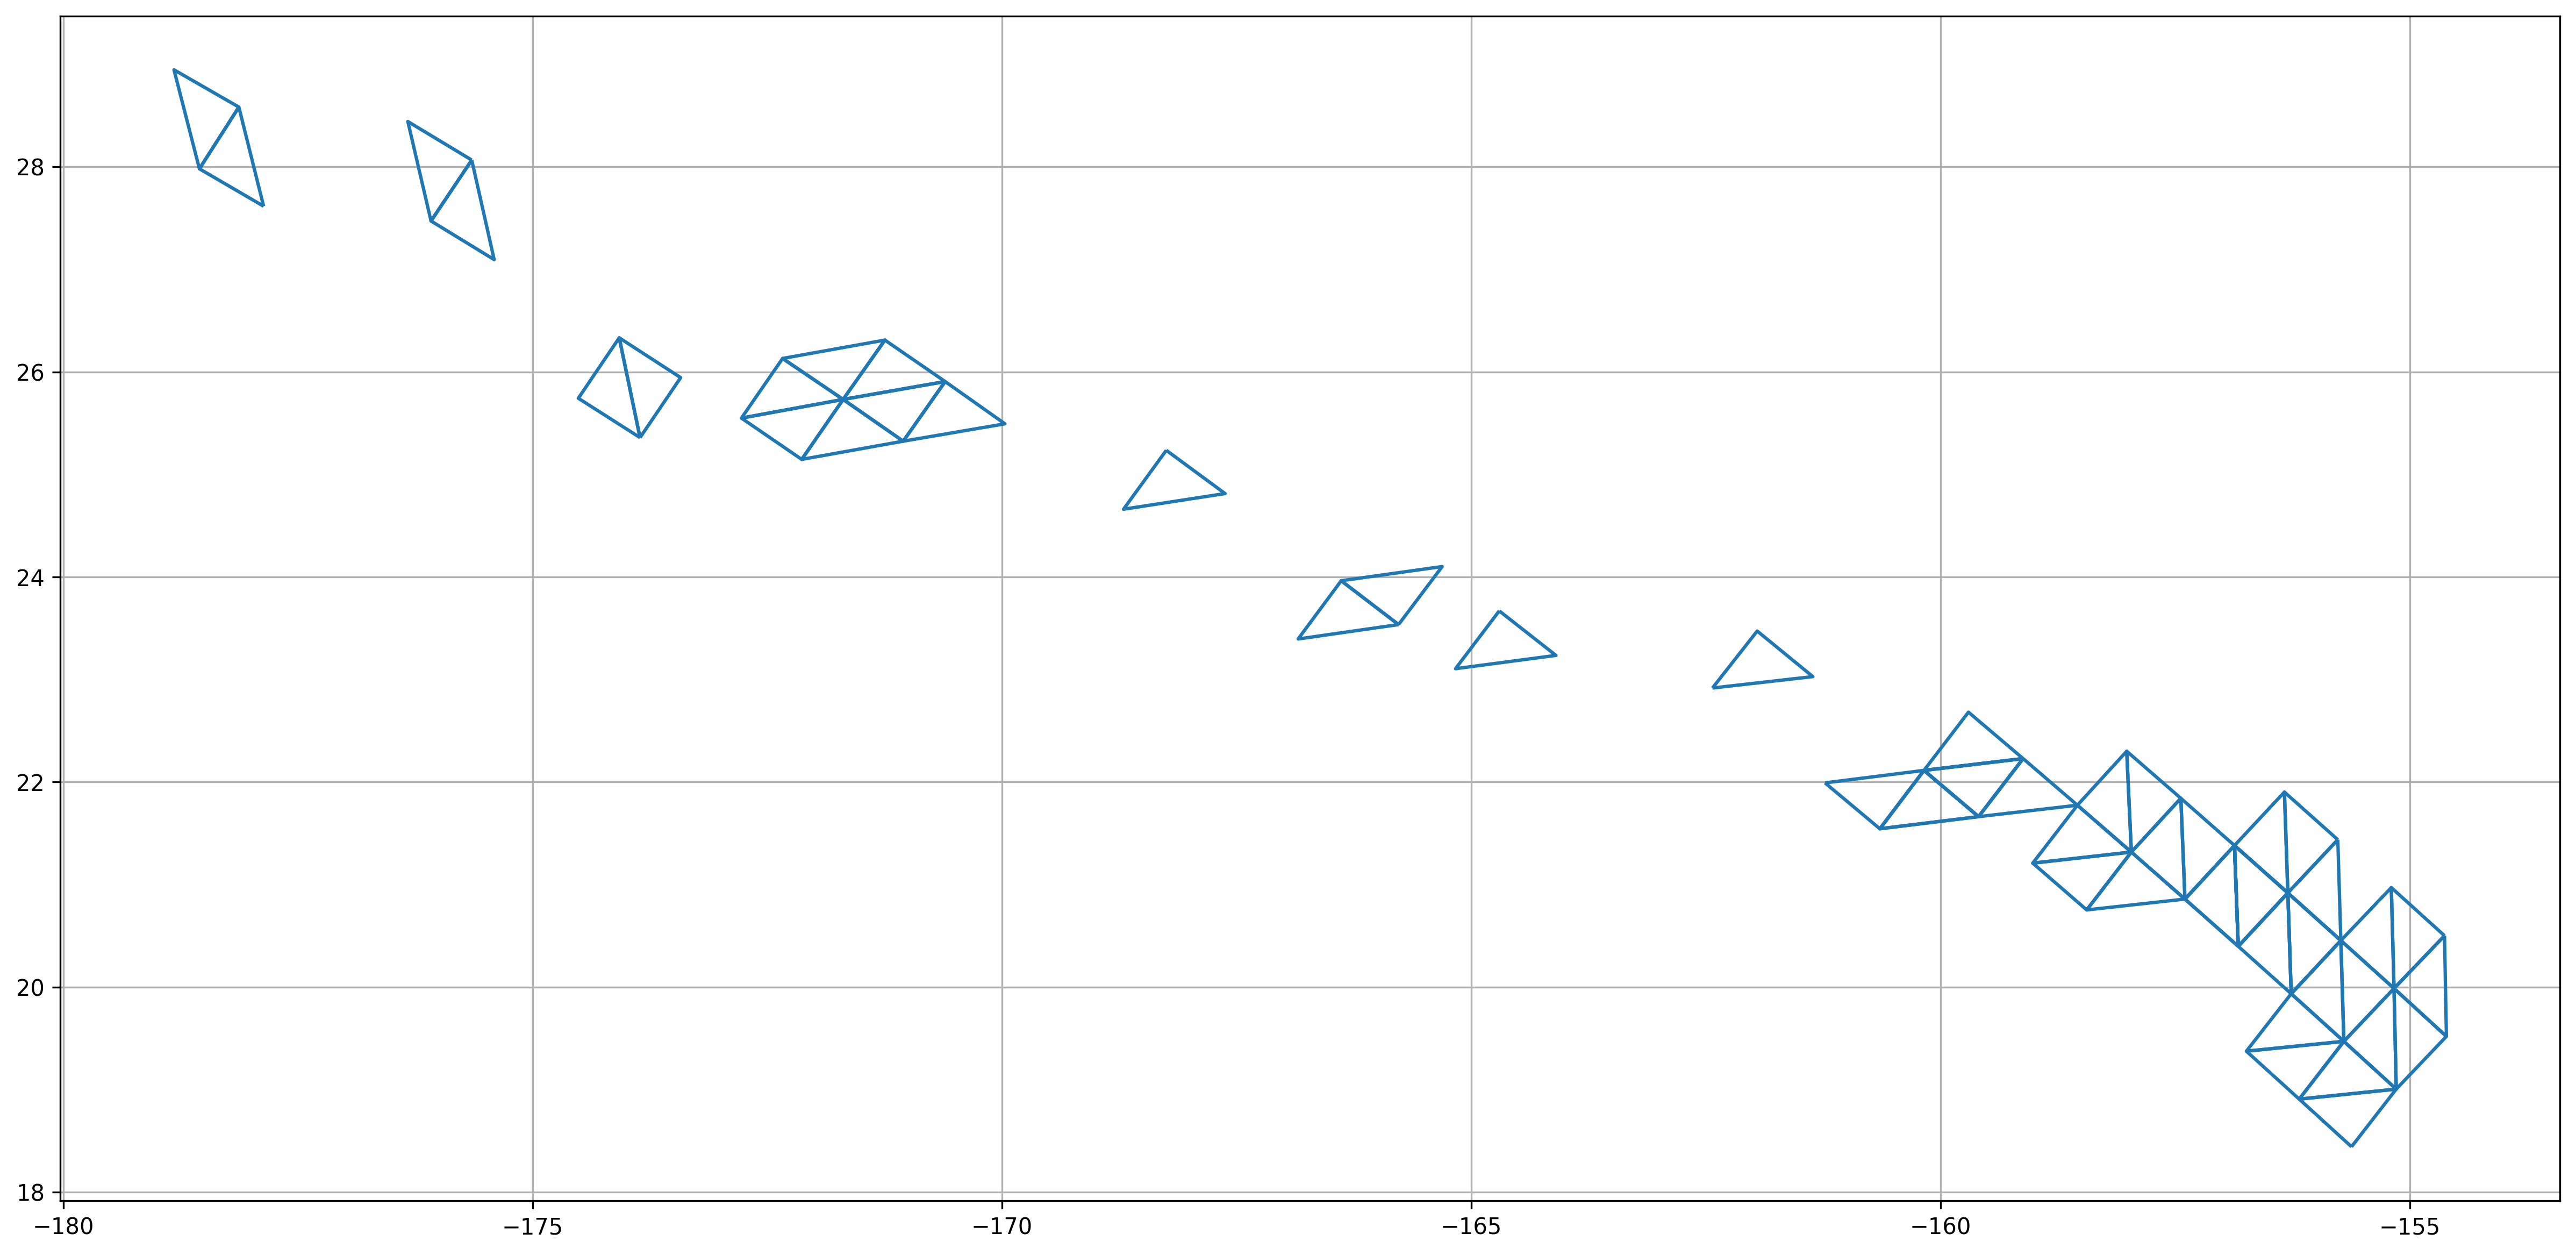

In [19]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
ax.grid(True)

hawaii = us[us['NAME']=='Hawaii']
hawaii.plot(ax=ax, trixels=True)
hawaii

# Parallel dissolve

In [22]:
us_regions = us.stare_dissolve(by='REGION', aggfunc='sum', n_workers=10, geom=False)

In [34]:
trixels = us_regions.trixels(n_workers=4)
us_regions.set_trixels(trixels, inplace=True)

<AxesSubplot:>

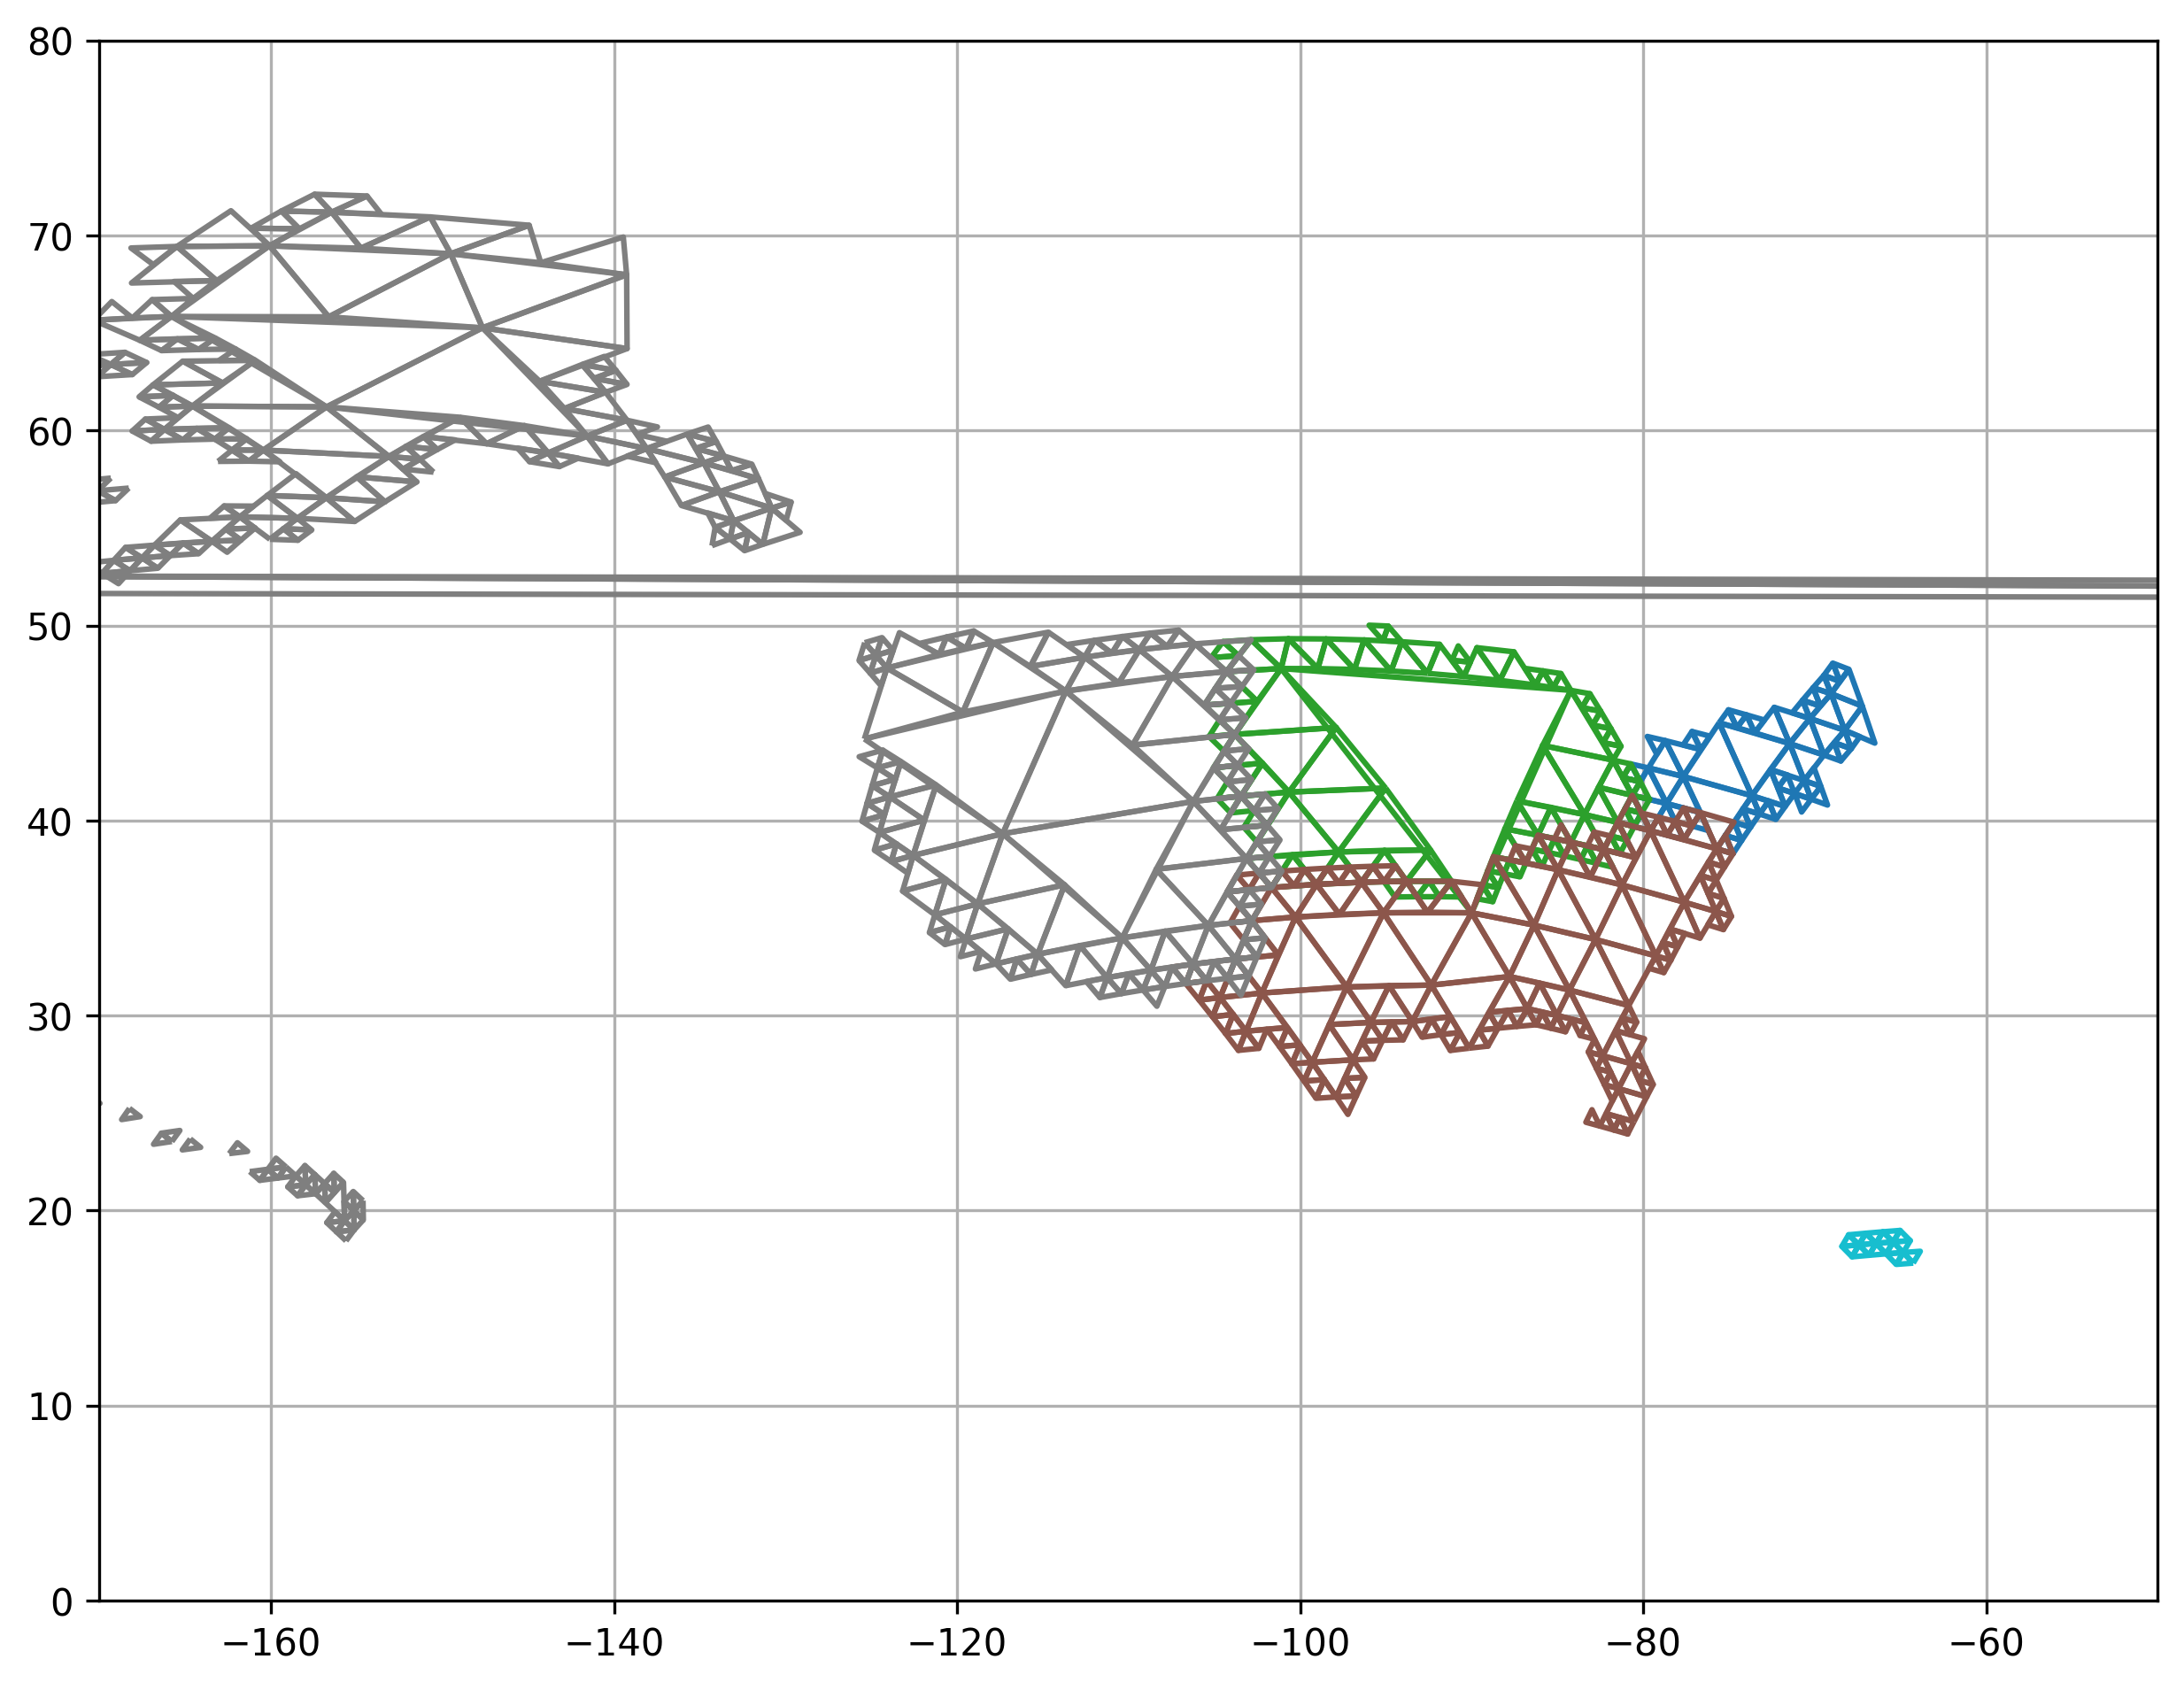

In [45]:
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax.grid(True)

ax.set_xlim(-170, -50)
ax.set_ylim(0, 80)

us_regions.reset_index().plot(ax=ax, trixels=True, column='REGION')